# Logisitc Regression

In [ ]:
import os
import time
from itertools import combinations_with_replacement
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from prettytable import PrettyTable
plt.style.use('seaborn')

## Load Data

In [ ]:
# unzip Fashion_MNIST.zip file
def download_data():
    if not os.path.exists('Fashion_MNIST'):
        !unzip '/content/drive/MyDrive/ColabNotebooks/Machine Learning/Logistic Regression/Fashion_MNIST.zip'
        print('Fashion_MNISR Down')
    else:
        print('Fashion_MNISR exists')
download_data()

Fashion_MNISR exists


In [ ]:
def load_data(data_path):
    """ File Architecture 

    Fashion_MNIST-
        |-0-
            |-0.png
            |-1.png
            |-...
        |-1
        |-2
        |-3
        |-4
    """
    classes = os.listdir(data_path)
    n_classes = len(classes) # 5
    images = []
    labels = []
    for c in classes:
        c_path = os.path.join(data_path, c)
        for img_name in os.listdir(c_path):
            img = Image.open(os.path.join(c_path, img_name)) # load iamge
            img = img.convert("L") # load image with gray scaling
            images.append(np.array(img)) # PIL -> array()
            labels.append(int(c)) # int() for string to value
    return np.array(images), np.array(labels)

DATA_DIR = 'Fashion_MNIST'
X, y = load_data(DATA_DIR)
print(X.shape, y.shape) 

(320, 28, 28) (320,)


## Split Train & Testing

Each classes 50:50 for training and testing

In [ ]:
def split_train_test(X, y, test_size=0.5, shuffle=False):
    """split data for training data and testing data"""
    x_train = []
    x_test = []
    y_train = []
    y_test = []

    for c in np.unique(y):
        idx = np.where(y==c)[0] # each classes's index
        x_c = X[idx]
        label_c = y[idx]
        split_size = int(len(x_c)*test_size)

        x_train.append(x_c[:split_size])
        x_test.append(x_c[split_size:])
        y_train.append(label_c[:split_size])
        y_test.append(label_c[split_size:])
    
    # list -> numpy.array
    x_train, x_test, y_train, y_test = \
    np.array(x_train).reshape(-1, 28*28), np.array(x_test).reshape(-1, 28*28), \
    np.array(y_train).reshape(-1), np.array(y_test).reshape(-1)

    if shuffle:
        random_idx = np.arange(len(x_train))
        np.random.shuffle(random_idx)
        x_train = x_train[random_idx]
        x_test = x_test[random_idx]
        y_train = y_train[random_idx]
        y_test = y_test[random_idx]

    return x_train, x_test, y_train, y_test

np.random.seed(10) # set random seed
x_train, x_test, y_train, y_test = split_train_test(X, y, test_size=0.5, shuffle=True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(160, 784) (160,)
(160, 784) (160,)


## One-hot Encode

In [ ]:
def LabelEncoder(y):
    if len(y.shape)==2:
        return y
    classes = np.unique(y)
    n_classes = len(classes)
    return np.eye(n_classes)[y]

# one-hot vector
y_train = LabelEncoder(y_train)
y_test = LabelEncoder(y_test)

# normalize
x_train = x_train/255.
x_test = x_test/255.

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(160, 784) (160, 5)
(160, 784) (160, 5)


## PCA

In [ ]:
class PCA:
    """Principal Component Analysis
    here are the implement steps:
    1. mean
    2. X - mean
    3. covariance
    4. eigenvalues, eigenvectors
    5. sorted eigenvectors base on eigenvalues
    6. components = eigenvectors[:k] 
    """
    def __init__(self, n_component=2):
        self.n_component = n_component
        self.components = None
        self.mean = None
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0) # (n_features, 1)
        self.std = np.std(X, axis=0, ddof=0)
        X = X - self.mean
        cov = np.cov(X.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1] # [::-1] -> decreasing sort
        self.eigenvalues = eigenvalues[idxs] 
        self.eigenvectors = eigenvectors[idxs]
        self.components = eigenvectors[0:self.n_component]

    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.components.T)
    
    def reconstruction(self, Z):
        return np.dot(Z, self.components) + self.mean # N x n_features 

## Polynomial features

In [ ]:
from itertools import combinations_with_replacement

def factorial(n):
    # single line to find factorial
    return np.array([1 if (n==1 or n==0) else n * factorial(n - 1)])

class PolynomialFeatures:

    def __init__(self, degree=2):
        self.degree = degree

    def fit(self, X):
        """
        X shape (N, M),
        N is sample size and M is feature size.
        output = (n+d)!/d!n!
        """
        self.n_features = X.shape[1]
        # calculate number of output feature size
        numerator = factorial(self.n_features + self.degree)
        denominator = factorial(self.degree) * factorial(self.n_features)
        self.n_output_features = int(numerator / denominator) - 1
    
    def transform(self, X):
        """transform to new features"""
        # combos is list of tuples indices to calculate polynomial features
        combos = [combinations_with_replacement(range(self.n_features), idx)
                for idx in range(1, self.degree+1)]
        # Create list of tuples containing feature index combinations.
        combinations = [item for sublist in combos for item in sublist]
        # to store new array from transformation
        X_new = np.empty((X.shape[0], self.n_output_features))

        for i, index_combos in enumerate(combinations):
            # np.pord can product specific axis
            X_new[:, i] = np.prod(X[:, index_combos], axis=1)

        return X_new
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

## Logistic Regression Model

In [ ]:
def softmax(inputs):
    """To avoid 'value expansion',
     inputs will minus a big values, 
     for example: inputs - max(inputs).
    """
    exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
    prob = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    return prob

def accuracy(y_pred, y_true):
    y_true = np.argmax(y_true, axis=1) if len(y_true.shape)==2 else y_true
    y_pred = np.argmax(y_pred, axis=1) if len(y_pred.shape)==2 else y_pred
    return np.mean(y_true == y_pred)

def crossentropy_loss(y_pred, y_true):
    """
    clip data to prevent divide zero,
    and both side clip in order to keep mean not change.
    """
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7) 
    return np.sum(-(y_true * np.log(y_pred_clipped))) / len(y_pred)


# SGD, batch_GD, Mini-batch GD
class SGD:
    """
    SGD: batch_size=1
    Batch GD: batch_size=N
    Mini-batch GD: batch_size=1<batch<M 
    """
    def __init__(self, learning_rate=0.001):
        self.lr = learning_rate

    def update_param(self, model, X, y):
        y_pred = softmax(np.dot(X, model.weights)+model.bias)
        
        dw = (1/model.sample_size) * np.dot(X.T, (y_pred - y))
        db = (1/model.sample_size) * np.sum(y_pred - y)

        model.weights -= self.lr * dw
        model.bias -= self.lr * db

# Newton Raphson Method
class NewtonRaphson:
    def __init__(self, learning_rate=0.001):
        self.lr = learning_rate
    
    def update_param(self, model, X, y):
        y_pred = softmax((np.dot(X, model.weights)+model.bias))
        
        # differential 1
        dw = (1/model.sample_size) * np.dot(X.T, (y_pred - y))
        db = (1/model.sample_size) * np.sum(y_pred - y)

        # differential 2 
        # 784x160 * 160x5 * 5x160 * 160x784
        d2w = (1/model.sample_size) * np.dot(X.T, np.dot(y, (1-y).T)).dot(X)

        model.weights += self.lr * np.linalg.pinv(d2w).dot(dw)


class LogisticRegression:
    """Logistic Regression
    initial weight vector to be a 'zero vector'.

    """
    def __init__(self, *, optimizer):
        self.weights = None
        self.bias = None
        self.optimizer = optimizer
    
    def fit(self, model, X, y, test_data: tuple=None, num_classes=5, batch_size=1, 
            epochs=100, imfo_print=None, shuffle=False, runtime: bool=False):

        self.X = X
        self.y = y

        if test_data is not None:
            x_test, y_test = test_data
    
        self.sample_size, self.n_features = X.shape
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.epochs = epochs
        self.totol_steps = int(np.ceil(self.sample_size/batch_size))

        self.weights = np.zeros((self.n_features, self.num_classes))
        self.bias = 0

        self.total_training_loss = []
        self.total_testing_loss = []
        self.total_training_acc = []
        self.total_testing_acc = []

        # shuffle
        if shuffle:
            idx = np.arange(self.sample_size)
            np.random.shuffle(idx)
            X = X[idx].copy()
            y = y[idx].copy()

        X = self.get_batch(X) # 5x32x784
        y = self.get_batch(y) # 5x32

        start = time.time()

        for epoch in range(epochs):
            for x, label in zip(X, y):
                self.optimizer.update_param(model, x, label)
            
            # train
            y_pred = softmax((np.dot(self.X, self.weights)+self.bias))
            training_loss = crossentropy_loss(y_pred, self.y)
            training_acc = accuracy(y_pred, self.y)
            self.total_training_loss.append(training_loss)
            self.total_training_acc.append(training_acc)

            # test
            y_pred = softmax((np.dot(x_test, self.weights)+self.bias))
            testing_loss = crossentropy_loss(y_pred, y_test)
            testing_acc = accuracy(y_pred, y_test)
            self.total_testing_loss.append(testing_loss)
            self.total_testing_acc.append(testing_acc)

            if imfo_print is not None:
                if (epoch+1) % imfo_print == 0:
                    print(f'【epoch: {epoch+1}】 training loss {training_loss:.3f}, trianing acc {training_acc:.3f}, testing loss {testing_loss:.3f} testing acc {testing_acc:.3f}')

            
        end = time.time()
        if runtime:
            print(f'Run time {end-start:.3f}/s')

    def predict(self, X):
        return softmax(np.dot(X, self.weights)+self.bias)

    def get_batch(self, inputs):
        return [inputs[self.batch_size*idx:self.batch_size*(idx+1)] for idx in range(self.totol_steps)]    


## 2-1 (a) Plot the learning curves

Plot the learning curves of E(w) and the accuracy of classification versus the number of epochs until convergence for training data as well as test data.

### Batch GD

In [ ]:
optimizer = SGD(learning_rate=0.01)
Batch_GD = LogisticRegression(optimizer=optimizer)
Batch_GD.fit(Batch_GD, x_train, y_train, test_data=(x_test, y_test), batch_size=len(x_train), epochs=100, imfo_print=10, shuffle=True)

【epoch: 10】 training loss 1.224, trianing acc 0.900, testing loss 1.227 testing acc 0.912
【epoch: 20】 training loss 0.999, trianing acc 0.906, testing loss 1.006 testing acc 0.912
【epoch: 30】 training loss 0.852, trianing acc 0.900, testing loss 0.863 testing acc 0.925
【epoch: 40】 training loss 0.751, trianing acc 0.894, testing loss 0.764 testing acc 0.925
【epoch: 50】 training loss 0.676, trianing acc 0.900, testing loss 0.691 testing acc 0.925
【epoch: 60】 training loss 0.619, trianing acc 0.906, testing loss 0.637 testing acc 0.925
【epoch: 70】 training loss 0.574, trianing acc 0.906, testing loss 0.593 testing acc 0.925
【epoch: 80】 training loss 0.538, trianing acc 0.906, testing loss 0.558 testing acc 0.931
【epoch: 90】 training loss 0.507, trianing acc 0.906, testing loss 0.530 testing acc 0.931
【epoch: 100】 training loss 0.482, trianing acc 0.906, testing loss 0.506 testing acc 0.931


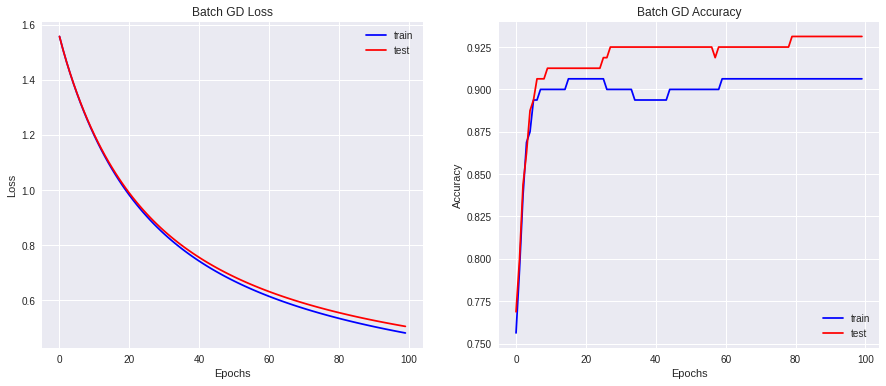

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
for p in range(2):
    if p == 0:
        ax[p].plot(range(Batch_GD.epochs), Batch_GD.total_training_loss, 'b-', label='train')
        ax[p].plot(range(Batch_GD.epochs), Batch_GD.total_testing_loss, 'r-', label='test')
        ax[p].set_xlabel('Epochs')
        ax[p].set_ylabel('Loss')
        ax[p].set_title('Batch GD Loss')
        ax[p].legend(loc='upper right')
    else:
        ax[p].plot(range(Batch_GD.epochs), Batch_GD.total_training_acc, 'b-', label='train')
        ax[p].plot(range(Batch_GD.epochs), Batch_GD.total_testing_acc, 'r-', label='test')
        ax[p].set_xlabel('Epochs')
        ax[p].set_ylabel('Accuracy')
        ax[p].set_title('Batch GD Accuracy')
        ax[p].legend(loc='lower right')


### Mini-batch SGD

In [ ]:
optimizer = SGD(learning_rate=0.01)
Mini_batchSGD = LogisticRegression(optimizer=optimizer)
Mini_batchSGD.fit(Mini_batchSGD, x_train, y_train, test_data=(x_test, y_test), batch_size=32, epochs=100, imfo_print=10, shuffle=True)

【epoch: 10】 training loss 1.227, trianing acc 0.900, testing loss 1.230 testing acc 0.919
【epoch: 20】 training loss 1.002, trianing acc 0.906, testing loss 1.009 testing acc 0.919
【epoch: 30】 training loss 0.855, trianing acc 0.900, testing loss 0.865 testing acc 0.925
【epoch: 40】 training loss 0.753, trianing acc 0.900, testing loss 0.766 testing acc 0.919
【epoch: 50】 training loss 0.678, trianing acc 0.900, testing loss 0.693 testing acc 0.919
【epoch: 60】 training loss 0.621, trianing acc 0.906, testing loss 0.638 testing acc 0.925
【epoch: 70】 training loss 0.576, trianing acc 0.906, testing loss 0.595 testing acc 0.931
【epoch: 80】 training loss 0.539, trianing acc 0.906, testing loss 0.560 testing acc 0.931
【epoch: 90】 training loss 0.508, trianing acc 0.906, testing loss 0.531 testing acc 0.931
【epoch: 100】 training loss 0.482, trianing acc 0.906, testing loss 0.507 testing acc 0.931


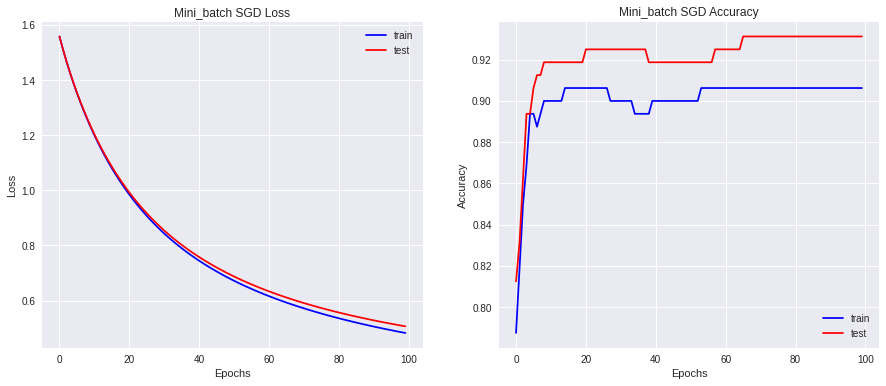

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
for p in range(2):
    if p == 0:
        ax[p].plot(range(Mini_batchSGD.epochs), Mini_batchSGD.total_training_loss, 'b-', label='train')
        ax[p].plot(range(Mini_batchSGD.epochs), Mini_batchSGD.total_testing_loss, 'r-', label='test')
        ax[p].set_xlabel('Epochs')
        ax[p].set_ylabel('Loss')
        ax[p].set_title('Mini_batch SGD Loss')
        ax[p].legend(loc='upper right')
    else:
        ax[p].plot(range(Mini_batchSGD.epochs), Mini_batchSGD.total_training_acc, 'b-', label='train')
        ax[p].plot(range(Mini_batchSGD.epochs), Mini_batchSGD.total_testing_acc, 'r-', label='test')
        ax[p].set_xlabel('Epochs')
        ax[p].set_ylabel('Accuracy')
        ax[p].set_title('Mini_batch SGD Accuracy')
        ax[p].legend(loc='lower right')


### SGD

In [ ]:
optimizer = SGD(learning_rate=0.01)
model_SGD = LogisticRegression(optimizer=optimizer)
model_SGD.fit(model_SGD, x_train, y_train, test_data=(x_test, y_test), batch_size=1, epochs=100, imfo_print=10, shuffle=True)

【epoch: 10】 training loss 1.227, trianing acc 0.900, testing loss 1.230 testing acc 0.919
【epoch: 20】 training loss 1.002, trianing acc 0.906, testing loss 1.009 testing acc 0.919
【epoch: 30】 training loss 0.855, trianing acc 0.900, testing loss 0.866 testing acc 0.925
【epoch: 40】 training loss 0.753, trianing acc 0.894, testing loss 0.766 testing acc 0.925
【epoch: 50】 training loss 0.678, trianing acc 0.900, testing loss 0.694 testing acc 0.925
【epoch: 60】 training loss 0.621, trianing acc 0.906, testing loss 0.638 testing acc 0.919
【epoch: 70】 training loss 0.576, trianing acc 0.906, testing loss 0.595 testing acc 0.925
【epoch: 80】 training loss 0.539, trianing acc 0.906, testing loss 0.560 testing acc 0.931
【epoch: 90】 training loss 0.509, trianing acc 0.906, testing loss 0.531 testing acc 0.931
【epoch: 100】 training loss 0.483, trianing acc 0.906, testing loss 0.507 testing acc 0.931


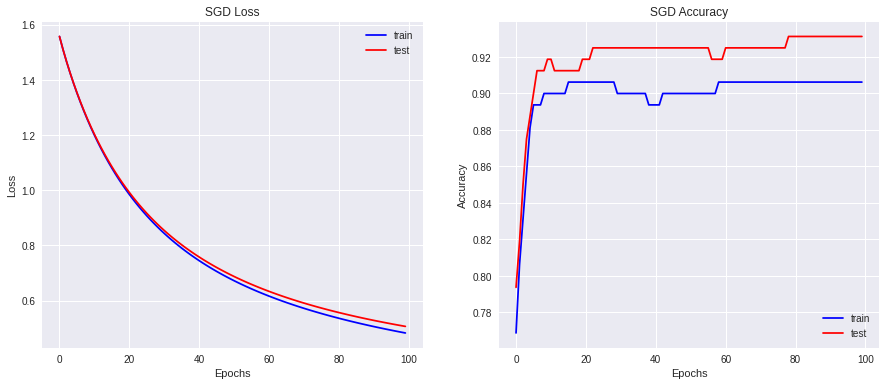

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
for p in range(2):
    if p == 0:
        ax[p].plot(range(model_SGD.epochs), model_SGD.total_training_loss, 'b-', label='train')
        ax[p].plot(range(model_SGD.epochs), model_SGD.total_testing_loss, 'r-', label='test')
        ax[p].set_xlabel('Epochs')
        ax[p].set_ylabel('Loss')
        ax[p].set_title('SGD Loss')
        ax[p].legend(loc='upper right')
    else:
        ax[p].plot(range(model_SGD.epochs), model_SGD.total_training_acc, 'b-', label='train')
        ax[p].plot(range(model_SGD.epochs), model_SGD.total_testing_acc, 'r-', label='test')
        ax[p].set_xlabel('Epochs')
        ax[p].set_ylabel('Accuracy')
        ax[p].set_title('SGD Accuracy')
        ax[p].legend(loc='lower right')


### Newton-Raphson

In [ ]:
optimizer = NewtonRaphson(learning_rate=10)
model_NewtonRaphson = LogisticRegression(optimizer=optimizer)
model_NewtonRaphson.fit(model_NewtonRaphson, x_train, y_train, test_data=(x_test, y_test), batch_size=len(x_train), epochs=100, imfo_print=10)

【epoch: 10】 training loss 0.590, trianing acc 0.900, testing loss 0.600 testing acc 0.912
【epoch: 20】 training loss 0.438, trianing acc 0.906, testing loss 0.447 testing acc 0.919
【epoch: 30】 training loss 0.381, trianing acc 0.900, testing loss 0.392 testing acc 0.912
【epoch: 40】 training loss 0.349, trianing acc 0.894, testing loss 0.365 testing acc 0.912
【epoch: 50】 training loss 0.329, trianing acc 0.894, testing loss 0.349 testing acc 0.919
【epoch: 60】 training loss 0.314, trianing acc 0.900, testing loss 0.338 testing acc 0.919
【epoch: 70】 training loss 0.302, trianing acc 0.900, testing loss 0.331 testing acc 0.919
【epoch: 80】 training loss 0.293, trianing acc 0.906, testing loss 0.325 testing acc 0.925
【epoch: 90】 training loss 0.285, trianing acc 0.906, testing loss 0.321 testing acc 0.925
【epoch: 100】 training loss 0.279, trianing acc 0.912, testing loss 0.318 testing acc 0.925


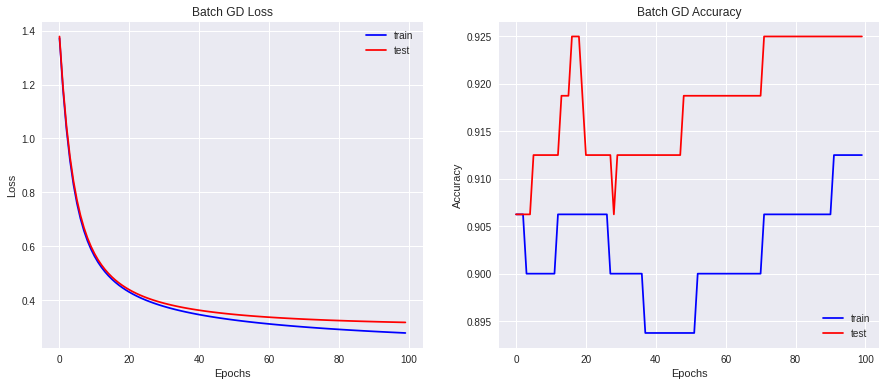

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
for p in range(2):
    if p == 0:
        ax[p].plot(range(model_NewtonRaphson.epochs), model_NewtonRaphson.total_training_loss, 'b-', label='train')
        ax[p].plot(range(model_NewtonRaphson.epochs), model_NewtonRaphson.total_testing_loss, 'r-', label='test')
        ax[p].set_xlabel('Epochs')
        ax[p].set_ylabel('Loss')
        ax[p].set_title('Batch GD Loss')
        ax[p].legend(loc='upper right')
    else:
        ax[p].plot(range(model_NewtonRaphson.epochs), model_NewtonRaphson.total_training_acc, 'b-', label='train')
        ax[p].plot(range(model_NewtonRaphson.epochs), model_NewtonRaphson.total_testing_acc, 'r-', label='test')
        ax[p].set_xlabel('Epochs')
        ax[p].set_ylabel('Accuracy')
        ax[p].set_title('Batch GD Accuracy')
        ax[p].legend(loc='lower right')


## 2-1 (b) Classification results

Show the classification results of training and test data.

In [ ]:
from prettytable import PrettyTable

def inferenece(model, X, y):
    y_pred = model.predict(X)
    return accuracy(y_pred, y)

# Batch GD
Batch_GD_train_acc = inferenece(Batch_GD, x_train, y_train)
Batch_GD_test_acc = inferenece(Batch_GD, x_test, y_test)
# Mini-batch GD
Mini_batchSGD_train_acc = inferenece(Mini_batchSGD, x_train, y_train)
Mini_batchSGD_test_acc = inferenece(Mini_batchSGD, x_test, y_test)
# SGD
model_SGD_train_acc = inferenece(model_SGD, x_train, y_train)
model_SGD_test_acc = inferenece(model_SGD, x_test, y_test)
# Newton-Raphason
model_NewtonRaphson_train_acc = inferenece(model_NewtonRaphson, x_train, y_train)
model_NewtonRaphson_test_acc = inferenece(model_NewtonRaphson, x_test, y_test)

table = PrettyTable()
table.title = 'Classification Result'
table.field_names = ['Type', 'Training accuracy', 'Test accuracy', 'Iterations']
table.add_row(['Batch GD', f'{Batch_GD_train_acc:.3f}', f'{Batch_GD_test_acc:.3f}', Batch_GD.totol_steps*Batch_GD.epochs])
table.add_row(['Mini-batch GD', f'{Mini_batchSGD_train_acc:.3f}', f'{Mini_batchSGD_test_acc:.3f}', Mini_batchSGD.totol_steps*Mini_batchSGD.epochs])
table.add_row(['SGD', f'{model_SGD_train_acc:.3f}', f'{model_SGD_test_acc:.3f}', model_SGD.totol_steps*model_SGD.epochs])
table.add_row(['Newton-Raphason', f'{model_NewtonRaphson_train_acc:.3f}', f'{model_NewtonRaphson_test_acc:.3f}', model_NewtonRaphson.totol_steps*model_NewtonRaphson.epochs])
print(table)

+------------------------------------------------------------------+
|                      Classification Result                       |
+-----------------+-------------------+---------------+------------+
|       Type      | Training accuracy | Test accuracy | Iterations |
+-----------------+-------------------+---------------+------------+
|     Batch GD    |       0.906       |     0.931     |    100     |
|  Mini-batch GD  |       0.906       |     0.931     |    500     |
|       SGD       |       0.906       |     0.931     |   16000    |
| Newton-Raphason |       0.912       |     0.925     |    100     |
+-----------------+-------------------+---------------+------------+


## 2-2 (a) Repeat 1 by using PCA

Repeat 1 by using PCA to reduce the dimension of images to d.

============================== Component = 2 ==============================


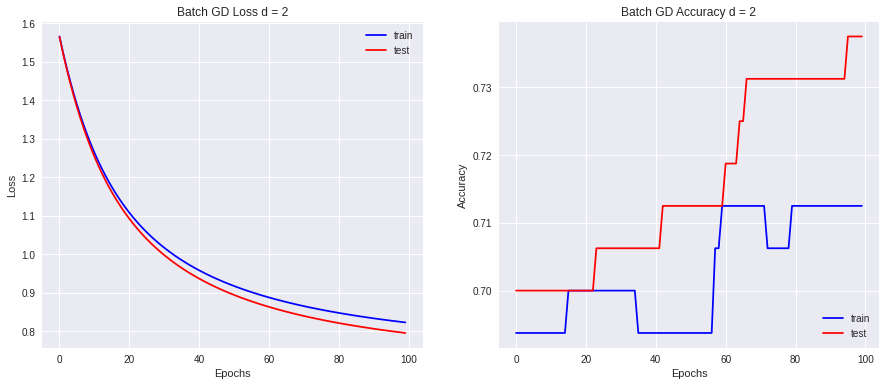

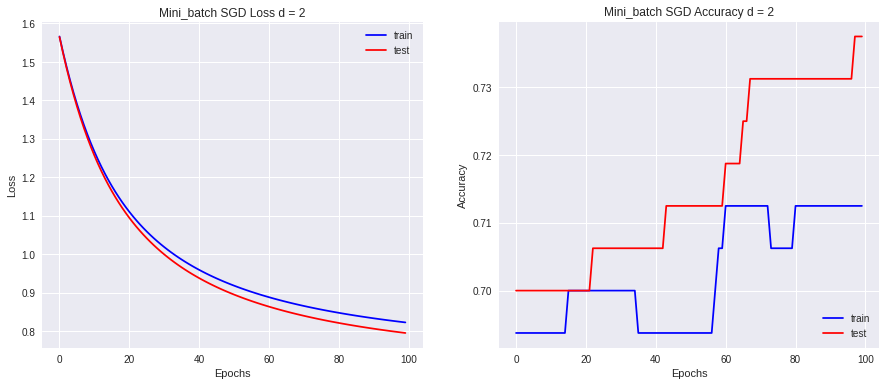

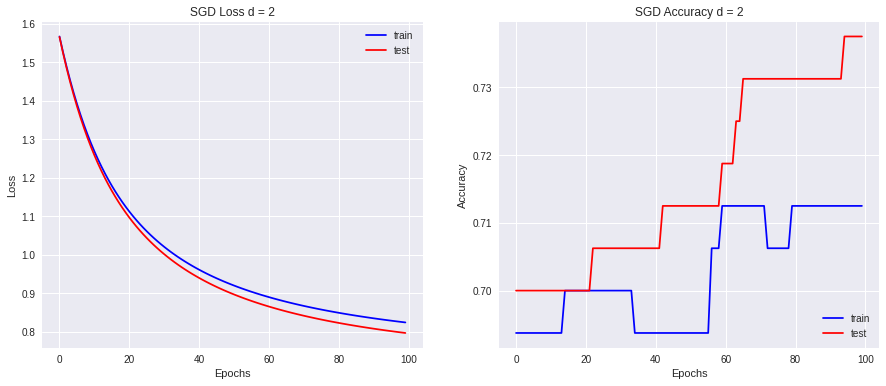

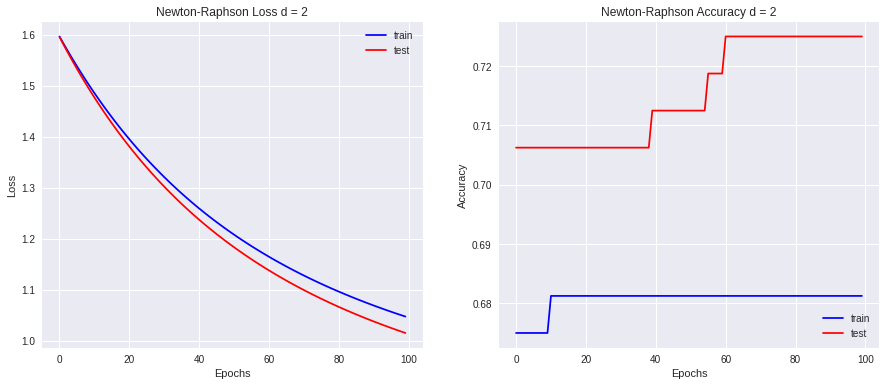

+----------------------------------------------------+
|            Classification Result d = 2             |
+----------------+-------------------+---------------+
|      Type      | Training accuracy | Test accuracy |
+----------------+-------------------+---------------+
|    Batch GD    |       0.7125      |     0.7375    |
| Mini_batch SGD |       0.7125      |     0.7375    |
|      SGD       |       0.7125      |     0.7375    |
| Newton-Raphson |      0.68125      |     0.725     |
+----------------+-------------------+---------------+

============================== Component = 5 ==============================


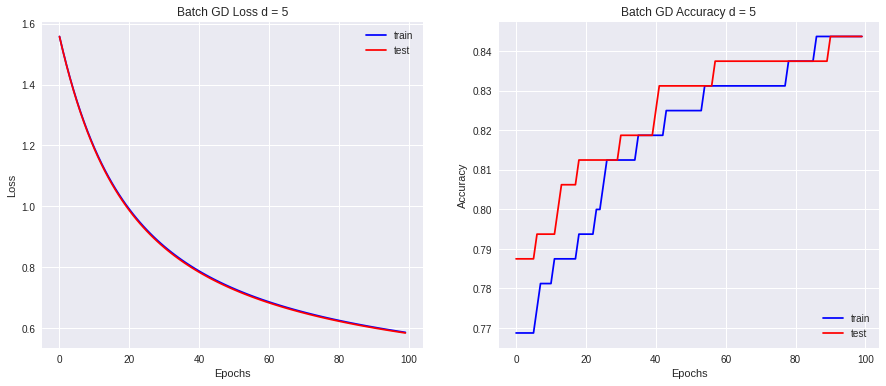

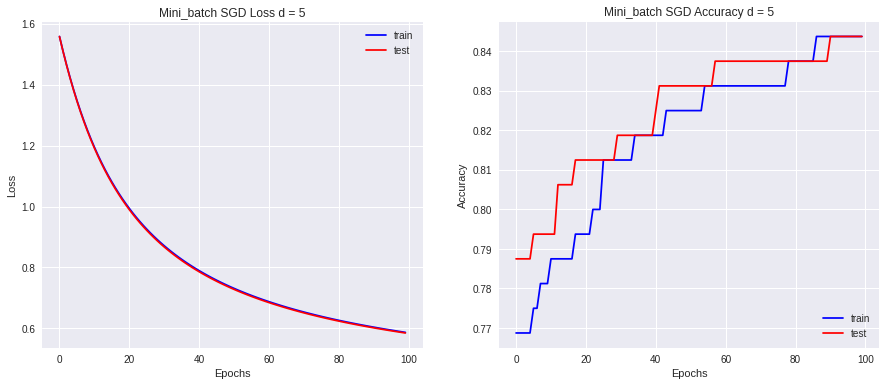

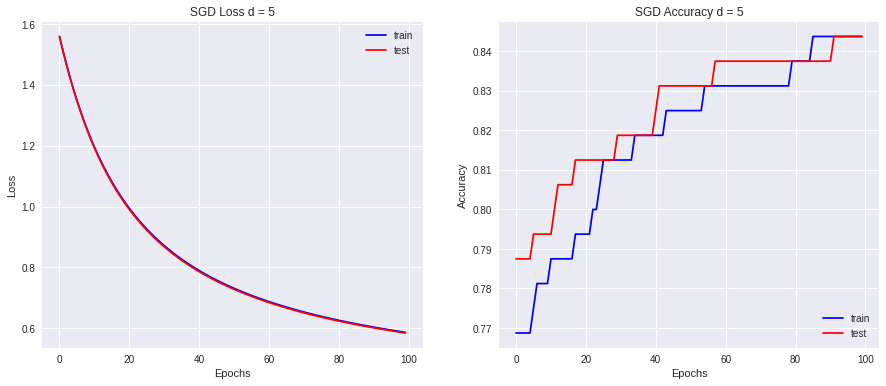

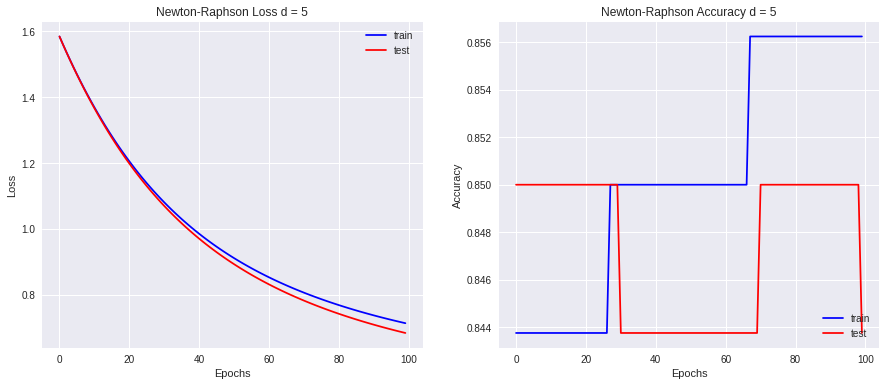

+----------------------------------------------------+
|            Classification Result d = 5             |
+----------------+-------------------+---------------+
|      Type      | Training accuracy | Test accuracy |
+----------------+-------------------+---------------+
|    Batch GD    |      0.84375      |    0.84375    |
| Mini_batch SGD |      0.84375      |    0.84375    |
|      SGD       |      0.84375      |    0.84375    |
| Newton-Raphson |      0.85625      |    0.84375    |
+----------------+-------------------+---------------+

============================== Component = 10 ==============================


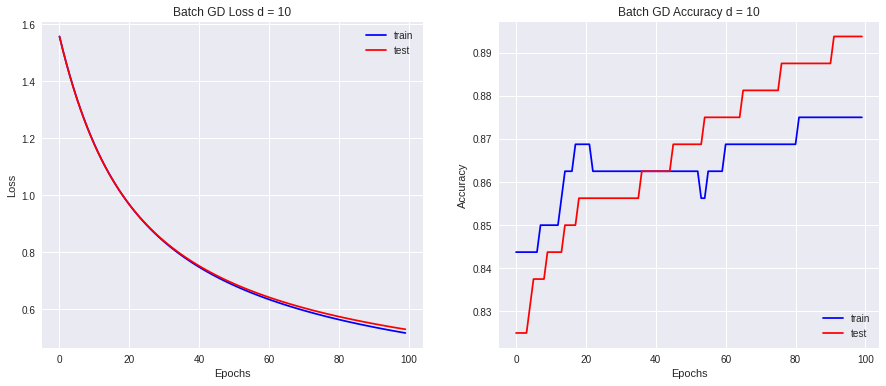

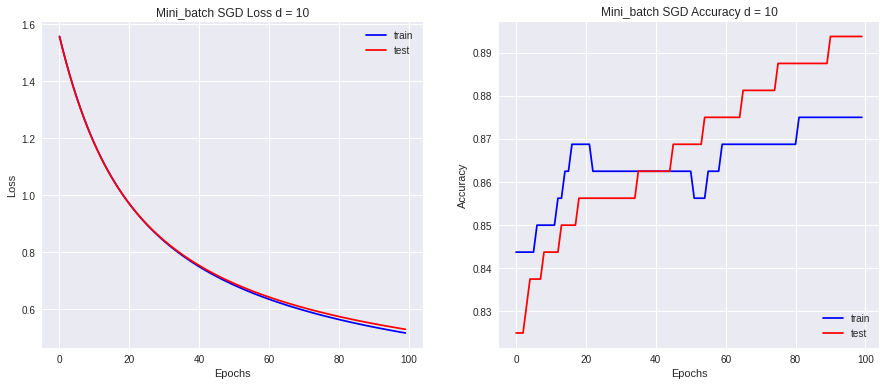

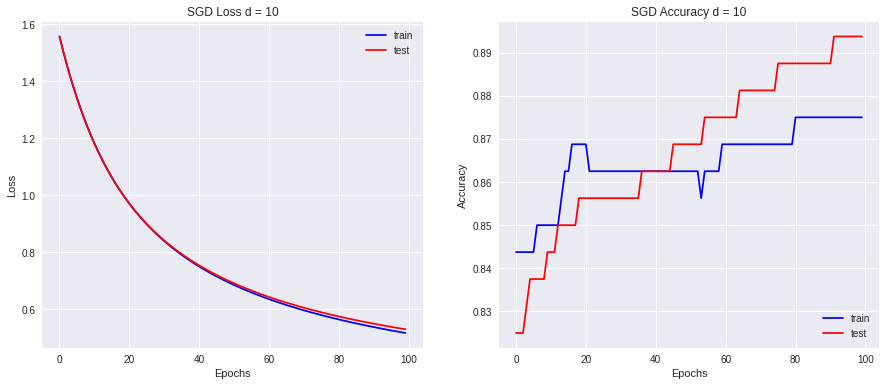

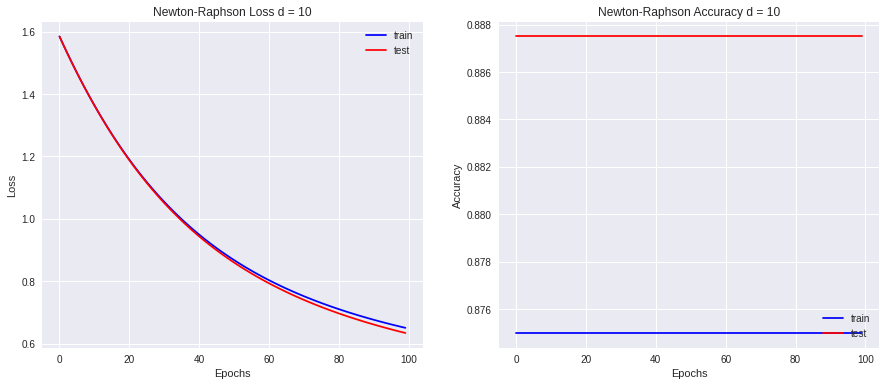

+----------------------------------------------------+
|            Classification Result d = 10            |
+----------------+-------------------+---------------+
|      Type      | Training accuracy | Test accuracy |
+----------------+-------------------+---------------+
|    Batch GD    |       0.875       |    0.89375    |
| Mini_batch SGD |       0.875       |    0.89375    |
|      SGD       |       0.875       |    0.89375    |
| Newton-Raphson |       0.875       |     0.8875    |
+----------------+-------------------+---------------+



In [ ]:
D = [2, 5, 10]
EPOCH = 100

for d in D:
    pca = PCA(n_component=d)
    pca.fit(x_train)
    x_train_pca = np.real(pca.transform(x_train))
    x_test_pca = np.real(pca.transform(x_test))
    print(f'{"="*30} Component = {d} {"="*30}')

    # Batch-GD
    optimizer = SGD(learning_rate=0.01)
    Batch_GD = LogisticRegression(optimizer=optimizer)
    Batch_GD.fit(Batch_GD, x_train_pca, y_train, test_data=(x_test_pca, y_test), batch_size=len(x_train), epochs=EPOCH, shuffle=True)
    
    # Mini-batch GD
    Mini_batchSGD = LogisticRegression(optimizer=optimizer)
    Mini_batchSGD.fit(Mini_batchSGD, x_train_pca, y_train, test_data=(x_test_pca, y_test), batch_size=32, epochs=EPOCH, shuffle=True)

    # SGD
    model_SGD = LogisticRegression(optimizer=optimizer)
    model_SGD.fit(model_SGD, x_train_pca, y_train, test_data=(x_test_pca, y_test), batch_size=1, epochs=EPOCH, shuffle=True)

    # Newton-Raphson
    optimizer = NewtonRaphson(learning_rate=1)
    model_NewtonRaphson = LogisticRegression(optimizer=optimizer)
    model_NewtonRaphson.fit(model_NewtonRaphson, x_train_pca, y_train, test_data=(x_test_pca, y_test), batch_size=len(x_train), epochs=EPOCH)

    model_list = [Batch_GD, Mini_batchSGD, model_SGD, model_NewtonRaphson]
    model_str = ['Batch GD', 'Mini_batch SGD', 'SGD', 'Newton-Raphson']
    training_acc = []
    testing_acc = []
    for idx, model in enumerate(model_list):
        fig, ax = plt.subplots(1, 2, figsize=(15,6))
        for p in range(2):
            if p == 0:
                ax[p].plot(range(model.epochs), model.total_training_loss, 'b-', label='train')
                ax[p].plot(range(model.epochs), model.total_testing_loss, 'r-', label='test')
                ax[p].set_xlabel('Epochs')
                ax[p].set_ylabel('Loss')
                ax[p].set_title(f'{model_str[idx]} Loss d = {d}')
                ax[p].legend(loc='upper right')
            else:
                ax[p].plot(range(model.epochs), model.total_training_acc, 'b-', label='train')
                ax[p].plot(range(model.epochs), model.total_testing_acc, 'r-', label='test')
                ax[p].set_xlabel('Epochs')
                ax[p].set_ylabel('Accuracy')
                ax[p].set_title(f'{model_str[idx]} Accuracy d = {d}')
                ax[p].legend(loc='lower right')
        plt.show()

        # inference
        train_acc = inferenece(model, x_train_pca, y_train)
        test_acc = inferenece(model, x_test_pca, y_test)
        training_acc.append(train_acc)
        testing_acc.append(test_acc)
    
    # create table
    field_names = ['Type', 'Training accuracy', 'Test accuracy', 'Iterations']
    table = PrettyTable()
    table.title = f'Classification Result d = {d}'
    table.add_column(field_names[0], [*model_str])
    table.add_column(field_names[1], [*training_acc])
    table.add_column(field_names[2], [*testing_acc])
    print(table)
    print()


## 2-2 (b) Plot Reconstruction Image

Plot d eigenvectors corresponding to top d eigenvalues.

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_reconstruction(array, d=2, sample_sequard: int=5):
    # choise n sample
    idxs = np.arange(len(array))
    img = [array[idx] for idx in idxs[:sample_sequard*sample_sequard]]

    fig = plt.figure(figsize=(8., 8.))
    grid = ImageGrid(fig, 111, nrows_ncols=(sample_sequard, sample_sequard), axes_pad=0.1)

    for ax, im in zip(grid, img):
        ax.imshow(im, cmap='gray')
    plt.title(f'd = {d}')
    plt.show()

======================= Component = 2 =======================


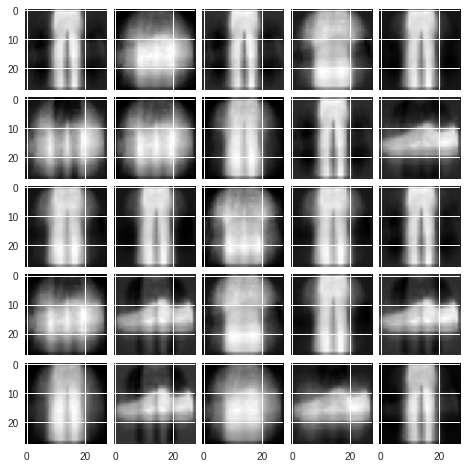

======================= Component = 5 =======================


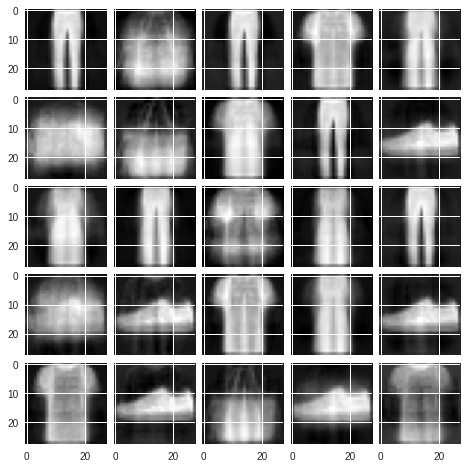

======================= Component = 10 =======================


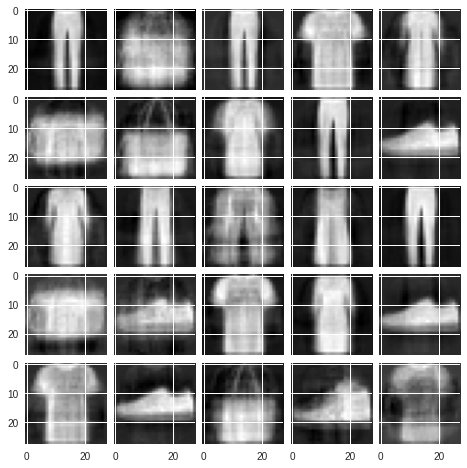

======================= Component = 784 =======================


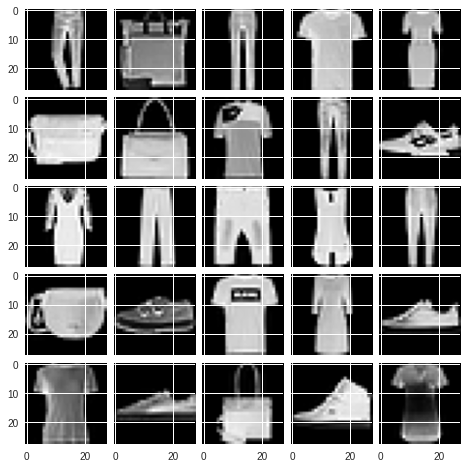

In [ ]:
K = [2, 5, 10, 784]

for d in K:
    print(f'{"="*23} Component = {d} {"="*23}')
    pca = PCA(n_component=d)
    pca.fit(x_train)
    train_pca = pca.transform(x_train)
    test_pca = pca.transform(x_test)

    # reconstruction
    recon_trian = np.real(pca.reconstruction(train_pca)).reshape(-1, 28, 28)
    recon_test = np.real(pca.reconstruction(test_pca)).reshape(-1, 28, 28)

    # plot reconstruction
    plot_reconstruction(recon_trian, d=d, sample_sequard=5)

## 2-3 Plot decision regions 

Plot the decision regions and data points of the images on the span of top 2 eigenvectors by using PCA to reduce the dimension of images to 2.

In [ ]:
plt.style.use('seaborn')
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
color_ticks = np.arange(-1, 5)


def plot_DicisionRegions(model, train_data: tuple, test_data: tuple, M=1, num=100, extend=4):
    
    pf = PolynomialFeatures(degree=M)
    x_train, y_train = train_data
    x_test, y_test = test_data
    
    x = np.linspace(np.min(x_train[:,0])-extend, np.max(x_train[:,0])+extend, num=num)
    y = np.linspace(np.min(x_train[:,1])-extend, np.max(x_train[:,1])+extend, num=num)
    x, y = np.meshgrid(x, y)
    data = pf.fit_transform(np.c_[x.flatten(), y.flatten()])
    z = np.argmax(model.predict(data), axis=1).reshape(x.shape)

    # plot contourf
    plt.contourf(x, y, z, levels=color_ticks, colors=color_list, alpha=0.5)

    # scarrter plot for each class
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)
    n_classes = len(np.unique(y_train))
    for c in range(n_classes):
        idx_train = np.where(y_train==c)[0]
        idx_test = np.where(y_test==c)[0]
        X_c, X_c_ = x_train[idx_train], x_test[idx_test]
        plt.scatter(X_c[:,0], X_c[:,1], c=color_list[c], marker='o', label=f'class {str(c)} train')
        plt.scatter(X_c_[:,0], X_c_[:,1], c=color_list[c], marker='x', label=f'class {str(c)} test')
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.title(f'M = {M}')
    plt.show()

### 2-3 (a) M = 1

In [ ]:
pca = PCA(n_component=2)
pca.fit(x_train)
x_train_pca = np.real(pca.transform(x_train))
x_test_pca = np.real(pca.transform(x_test))

In [ ]:
M = 1

pf = PolynomialFeatures(M)
x_train_m1 = pf.fit_transform(x_train_pca)
x_test_m1 = pf.fit_transform(x_test_pca)
# training classify
optimizer = SGD(learning_rate=0.01)
model = LogisticRegression(optimizer=optimizer)
model.fit(model, x_train_m1, y_train, test_data=(x_test_m1, y_test), batch_size=32, epochs=10000, imfo_print=1000, shuffle=True)

【epoch: 1000】 training loss 0.728, trianing acc 0.731, testing loss 0.705 testing acc 0.725
【epoch: 2000】 training loss 0.724, trianing acc 0.731, testing loss 0.706 testing acc 0.725
【epoch: 3000】 training loss 0.722, trianing acc 0.731, testing loss 0.707 testing acc 0.725
【epoch: 4000】 training loss 0.722, trianing acc 0.731, testing loss 0.708 testing acc 0.725
【epoch: 5000】 training loss 0.721, trianing acc 0.725, testing loss 0.709 testing acc 0.725
【epoch: 6000】 training loss 0.721, trianing acc 0.725, testing loss 0.710 testing acc 0.725
【epoch: 7000】 training loss 0.721, trianing acc 0.725, testing loss 0.711 testing acc 0.725
【epoch: 8000】 training loss 0.721, trianing acc 0.725, testing loss 0.711 testing acc 0.725
【epoch: 9000】 training loss 0.721, trianing acc 0.725, testing loss 0.711 testing acc 0.725
【epoch: 10000】 training loss 0.721, trianing acc 0.725, testing loss 0.712 testing acc 0.725


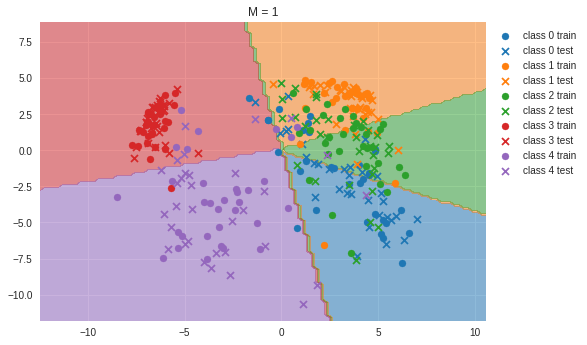

In [ ]:
plot_DicisionRegions(model, train_data=(x_train_pca, y_train), test_data=(x_test_pca, y_test), M=M)

### 2-3 (b) M = 2

In [ ]:
M = 2

pf = PolynomialFeatures(degree=M)
x_train_m2 = pf.fit_transform(x_train_pca)
x_test_m2 = pf.fit_transform(x_test_pca)
# training classify
optimizer = SGD(learning_rate=0.01)
model = LogisticRegression(optimizer=optimizer)
model.fit(model, x_train_m2, y_train, test_data=(x_test_m2, y_test), batch_size=32, epochs=10000, imfo_print=1000, shuffle=True)

【epoch: 1000】 training loss 0.582, trianing acc 0.738, testing loss 0.633 testing acc 0.731
【epoch: 2000】 training loss 0.563, trianing acc 0.744, testing loss 0.640 testing acc 0.769
【epoch: 3000】 training loss 0.554, trianing acc 0.744, testing loss 0.648 testing acc 0.762
【epoch: 4000】 training loss 0.550, trianing acc 0.750, testing loss 0.656 testing acc 0.762
【epoch: 5000】 training loss 0.547, trianing acc 0.762, testing loss 0.664 testing acc 0.762
【epoch: 6000】 training loss 0.546, trianing acc 0.762, testing loss 0.670 testing acc 0.769
【epoch: 7000】 training loss 0.545, trianing acc 0.762, testing loss 0.675 testing acc 0.769
【epoch: 8000】 training loss 0.544, trianing acc 0.762, testing loss 0.680 testing acc 0.781
【epoch: 9000】 training loss 0.544, trianing acc 0.762, testing loss 0.683 testing acc 0.781
【epoch: 10000】 training loss 0.543, trianing acc 0.762, testing loss 0.684 testing acc 0.781


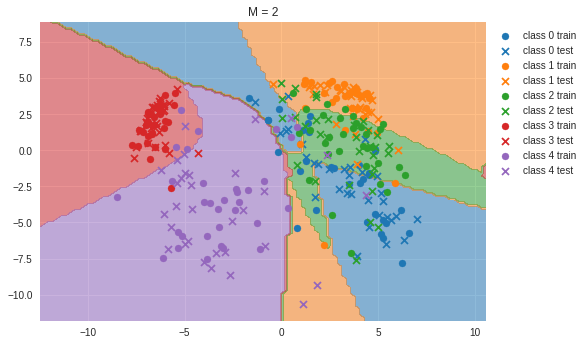

In [ ]:
plot_DicisionRegions(model, train_data=(x_train_pca, y_train), test_data=(x_test_pca, y_test), M=M)